# Rag-based LLM Application

## Set up

In [1]:
import os
import openai
from pathlib import Path
from pprint import pprint
import ray
from tqdm import tqdm

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')
from dotenv import load_dotenv; load_dotenv()
from app.config import ROOT_DIR

In [3]:
# Database credentials
ray.init(runtime_env={"env_vars": {"DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"]}, "working_dir": ROOT_DIR})

2023-08-22 15:42:46,501	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 10.0.10.245:6379...
2023-08-22 15:42:46,537	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at https://session-be1hnldal9xip1fnc7xnpqwxz8.i.anyscaleuserdata-staging.com 
2023-08-22 15:42:46,583	INFO packaging.py:518 -- Creating a file package for local directory '/home/ray/ray-assistant/notebooks/..'.
2023-08-22 15:42:46,633	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_61f398f7369130df.zip' (7.99MiB) to Ray cluster...
2023-08-22 15:42:46,658	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_61f398f7369130df.zip'.


Python version:,3.8.13
Ray version:,2.6.3
Dashboard:,http://session-be1hnldal9xip1fnc7xnpqwxz8.i.anyscaleuserdata-staging.com


## Load data

Our data is already ready at `/efs/shared_storage/pcmoritz/docs.ray.io/en/master/` (on Staging, `us-east-1`) but if you wanted to load it yourself, run this bash command (change `/desired/output/directory`, but make sure it's on the shared storage,
so that it's accessible to the workers):
```bash
export DOCS_PATH=/desired/output/directory
wget -e robots=off --recursive --no-clobber --page-requisites \
  --html-extension --convert-links --restrict-file-names=windows \
  --domains docs.ray.io --no-parent --accept=html \
  -P $DOCS_PATH https://docs.ray.io/en/master/
```

In [4]:
# Ray dataset
docs_path = Path("/efs/shared_storage/pcmoritz/docs.ray.io/en/master/")
ds = ray.data.from_items([{"path": path} for path in docs_path.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

3294 documents


## Process data

### Sections

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from app.index import parse_file

In [13]:
# Paste any URL from https://docs.ray.io/en/master/ (ex. https://docs.ray.io/en/master/train/faq.html)
docs_page_url = input()
path = f"{str(docs_path)}/{docs_page_url.split('docs.ray.io/en/master/')[-1]}"
print (path)

 https://docs.ray.io/en/master/train/faq.html


/efs/shared_storage/pcmoritz/docs.ray.io/en/master/train/faq.html


In [14]:
# Sample
record = {"path": path}
pprint(parse_file(record)[:3])  # just first few chunks

[{'source': 'https://docs.ray.io/en/master/train/faq.html', 'text': '\n\n\n'},
 {'source': 'https://docs.ray.io/en/master/train/faq.html#ray-train-faq',
  'text': 'Ray Train FAQ#\n\n'},
 {'source': 'https://docs.ray.io/en/master/train/faq.html#how-fast-is-ray-train-compared-to-pytorch-tensorflow-etc',
  'text': 'How fast is Ray Train compared to PyTorch, TensorFlow, etc.?#\n'
          'At its core, training speed should be the same - while Ray Train '
          'launches distributed training workers via Ray Actors,\n'
          'communication during training (e.g. gradient synchronization) is '
          'handled by the backend training framework itself.\n'
          'For example, when running Ray Train with the TorchTrainer,\n'
          'distributed training communication is done with Torch’s '
          'DistributedDataParallel.\n'
          'Take a look at the Pytorch and Tensorflow benchmarks to check '
          'performance parity.\n'
          '\n'
          '\n'}]


In [15]:
# Extract sections
sections_ds = ds.flat_map(parse_file)
sections = sections_ds.take_all()
print (len(sections))

2023-08-22 15:47:37,476	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(parse_file)]
2023-08-22 15:47:37,477	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 15:47:37,479	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(FlatMap(parse_file) pid=27201) /tmp/ray/session_2023-08-22_15-18-04_608227_2519/runtime_resources/working_dir_files/_ray_pkg_61f398f7369130df/app/index.py:21: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.
(FlatMap(parse_file) pid=27201) 
(FlatMap(parse_file) pid=27201) The code that caused this warning is on line 21 of the file /tmp/ray/session_2023-08-22_15-18-04_608227_2519/runtime_resources/working_dir_files/_ray_pkg_61f398f7369130df/app/index.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.
(FlatMap(parse_file) pid=27201) 
(FlatMap(parse_file) pid=27201)   soup = BeautifulSoup(f.read())
(FlatMap(parse_file) pid=27205) /tmp/ray/session_2023-08-22_15-18-04_608

8913
(autoscaler +5m14s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}
(autoscaler +5m20s) [workspace snapshot] New snapshot created successfully (size: 8.00 MB).


In [16]:
# Stats summary
sections_lengths = [len(section["text"]) for section in sections]
series = pd.Series(sections_lengths)
series.describe()

count      8913.000000
mean       1335.435095
std        5963.464153
min           3.000000
25%           3.000000
50%         251.000000
75%         809.000000
max      208012.000000
dtype: float64

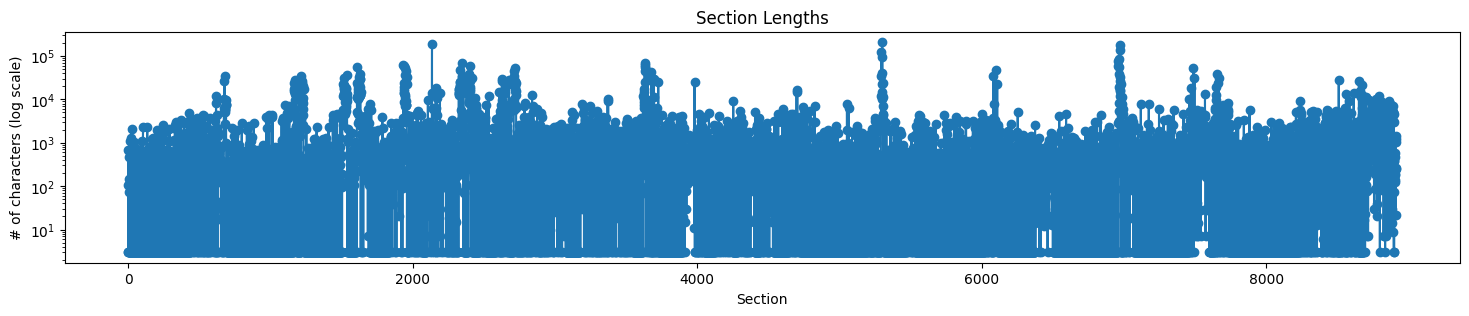

In [17]:
# Sections lengths
plt.figure(figsize=(18, 3))
plt.semilogy(sections_lengths, marker='o')
plt.xlabel('Section')
plt.ylabel('# of characters (log scale)')
plt.title('Section Lengths')
plt.show()

### Chunks

Some of these sections are very large, let's apply some chunking to improve this so that we can use these sections as context later.

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [19]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=50,
    length_function=len,
)

In [20]:
chunks = text_splitter.create_documents(
    texts=[section["text"] for section in sections], 
    metadatas=[{"source": section["source"]} for section in sections]
)

In [21]:
print (f"{len(chunks)} chunks\n")
pprint (chunks[0].page_content)  # a few tokens
print (f"\nmetadata:\n{chunks[0].metadata}")

57835 chunks

('ray.tune.schedulers.pb2.PB2.CONTINUE#\n'
 '\n'
 '\n'
 "PB2.CONTINUE = 'CONTINUE'#\n"
 'Status for continuing trial execution')

metadata:
{'source': 'https://docs.ray.io/en/master/tune/api/doc/ray.tune.schedulers.pb2.PB2.CONTINUE.html#ray-tune-schedulers-pb2-pb2-continue'}


In [22]:
# Ray dataset
chunks_ds = ray.data.from_items([{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks])

### Embed data

In [23]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import numpy as np
from ray.data import ActorPoolStrategy

In [33]:
embedding_model_name = "thenlper/gte-base"

In [43]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"device": "cuda", "batch_size": 100})
    
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

In [44]:
# Embed chunks
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=2))

In [45]:
# Sample
sample = embedded_chunks.take(5)
print ("embedding size:", len(sample[0]["embeddings"]))
pprint(sample[0]["text"])

2023-08-22 16:10:48,085	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedChunks)]
2023-08-22 16:10:48,086	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 16:10:48,087	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-22 16:10:48,109	INFO actor_pool_map_operator.py:117 -- MapBatches(EmbedChunks): Waiting for 2 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-08-22 16:11:12,022	WARNING actor_pool_map_operator.py:275 -- To ensure full parallelization across an actor pool of size 2, the Dataset should consist of at least 2 distinct blocks. Consider increasing the parallelism when creating the Dataset.


embedding size: 768
('Parameters\n'
 'values – An iterable whose parameters will be used for creating a trial '
 'grid.\n'
 '\n'
 '\n'
 'PublicAPI (beta): This API is in beta and may change before becoming stable.')


### Index data

In [49]:
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                    cur.execute("INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)", (text, source, embedding,),)
        return {}

In [50]:
# Index data
embedded_chunks.map_batches(
    StoreResults,
    batch_size=128,
    num_cpus=1,
    compute=ActorPoolStrategy(size=28),
).count()

2023-08-22 16:27:02,788	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2023-08-22 16:27:02,789	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 16:27:02,790	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-22 16:27:02,811	INFO actor_pool_map_operator.py:117 -- MapBatches(EmbedChunks): Waiting for 2 pool actors to start...
2023-08-22 16:27:23,874	INFO actor_pool_map_operator.py:117 -- MapBatches(StoreResults): Waiting for 28 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +45m26s) [workspace snapshot] New snapshot created successfully (size: 8.00 MB).
(autoscaler +50m27s) [workspace snapshot] New snapshot created successfully (size: 8.00 MB).


2023-08-22 16:35:04,888	WARNING actor_pool_map_operator.py:267 -- To ensure full parallelization across an actor pool of size 28, the specified batch size should be at most 0. Your configured batch size for this operator was 128.


0

### Retrieval

In [51]:
import json
import numpy as np
import psycopg
from pgvector.psycopg import register_vector

In [52]:
embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)
conn = psycopg.connect(os.environ["DB_CONNECTION_STRING"])
register_vector(conn)

In [53]:
# Embed query
query = "What is the default batch size for map_batches?"
embedding = np.array(embedding_model.embed_query(query))
len(embedding)

768

In [66]:
with conn.cursor() as cur:
    cur.execute("SELECT * FROM document ORDER BY embedding <-> %s LIMIT 5", (embedding,))
    rows = cur.fetchall()
    context = [{"text": row[1], "source": row[2]} for row in rows]

In [67]:
for item in context:
    print (item["source"])
    print (item["text"])
    print ()

https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches
entire blocks as batches (blocks may contain different numbers of rows).
The actual size of the batch provided to fn may be smaller than
batch_size if batch_size doesn’t evenly divide the block(s) sent
to a given map task. Default batch_size is 4096 with “default”.

https://docs.ray.io/en/master/_modules/ray/data/dataset.html
``batch_size`` if ``batch_size`` doesn't evenly divide the block(s) sent
                to a given map task. Default batch_size is 4096 with "default".
            compute: Either "tasks" (default) to use Ray Tasks or an

https://docs.ray.io/en/master/ray-air/api/doc/ray.data.preprocessors.BatchMapper.html#ray-data-preprocessors-batchmapper
contain different number of rows) and the actual size of the batch provided
to fn may be smaller than batch_size if batch_size doesn’t
evenly divide the block(s) sent to a given map task. Defaults to 4096,
which is the sam

### Generation

In [68]:
import time

In [56]:
def generate_response(
    llm, temperature=0.0, 
    system_content="", assistant_content="", user_content="", 
    max_retries=3, retry_interval=60):
    """Generate response from an LLM."""
    retry_count = 0
    while retry_count < max_retries:
        try:
            response = openai.ChatCompletion.create(
                model=llm,
                temperature=temperature,
                messages=[
                    {"role": "system", "content": system_content},
                    {"role": "assistant", "content": assistant_content},
                    {"role": "user", "content": user_content},
                ],
            )
            return response["choices"][-1]["message"]["content"]
        except Exception as e:
            print(e)
            time.sleep(retry_interval)  # default is per-minute rate limits
            retry_count += 1
    return ""

In [57]:
# Credentials
openai.api_base = os.environ["ANYSCALE_API_BASE"]
openai.api_key = os.environ["ANYSCALE_API_KEY"]

In [59]:
# Generate response
generate_response(
    llm="meta-llama/Llama-2-70b-chat-hf",
    temperature=0.0,
    system_content="Answer the {query} using the provided {context}",
    user_content=f"query: {query}, context: {context}"
)

'The default batch size for map_batches is 4096. This is mentioned in multiple places in the provided context, including the Ray documentation for Dataset.map_batches, BatchMapper, and data transformation. The default batch size is also defined in the Ray source code, specifically in the ray.data.context module.\n\nHere are some relevant quotes from the provided context:\n\n* "Default batch size is 4096 with \'default\'." (from Dataset.map_batches documentation)\n* "Default batch size is 4096." (from BatchMapper documentation)\n* "The default batch size depends on your resource type. If you’re using CPUs, the default batch size is 4096." (from data transformation documentation)\n* "DEFAULT_BATCH_SIZE = 4096" (from ray.data.context module)\n\nTherefore, the answer to the query is 4096.'

### Query Agent

Let's combine the retrieval and response generation together into a query agent.

In [88]:
class QueryAgent:
    def __init__(self, embedding_model_name="thenlper/gte-base",
                 llm="meta-llama/Llama-2-70b-chat-hf", 
                 temperature=0.0, max_context_length=4096,
                 system_content="", assistant_content=""):
        self.embedding_model = HuggingFaceEmbeddings(model_name=embedding_model_name)
        self.llm = llm
        self.temperature = temperature
        self.context_length = max_context_length - len(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

        # VectorDB connection
        self.conn = psycopg.connect(os.environ["DB_CONNECTION_STRING"])
        register_vector(self.conn)

    def get_response(self, query):
        # Get context
        embedding = np.array(self.embedding_model.embed_query(query))
        with self.conn.cursor() as cur:
            cur.execute("SELECT * FROM document ORDER BY embedding <-> %s LIMIT 5", (embedding,))
            rows = cur.fetchall()
            context = [{"text": row[1]} for row in rows]
            sources = [row[2] for row in rows]

        # Generate response
        user_content = f"query: {query}, context: {context}"
        answer = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=user_content[: self.context_length],
        )

        # Result
        result = {
            "question": query,
            "sources": sources,
            "answer": answer,
        }
        return result

In [89]:
query = "What is the default batch size for map_batches?"
system_content = "Your job is to answer a question using the additional context provided."
agent = QueryAgent(
    embedding_model_name="thenlper/gte-base",
    llm="meta-llama/Llama-2-7b-chat-hf",
    max_context_length=4096,
    system_content=system_content,
)
result = agent.get_response(query=query)
print(json.dumps(result, indent=2))

{
  "question": "What is the default batch size for map_batches?",
  "sources": [
    "https://docs.ray.io/en/master/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches",
    "https://docs.ray.io/en/master/_modules/ray/data/dataset.html",
    "https://docs.ray.io/en/master/ray-air/api/doc/ray.data.preprocessors.BatchMapper.html#ray-data-preprocessors-batchmapper",
    "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-size",
    "https://docs.ray.io/en/master/_modules/ray/data/context.html"
  ],
  "answer": "The default batch size for `map_batches` is 4096, as specified in the context provided. However, it's important to note that the actual batch size provided to the function may be smaller than the default batch size if the block(s) sent to a given map task don't evenly divide the batch size. Additionally, the default batch size may vary depending on the resource type being used, with a default batch size of 4096 for CPUs and a differ

### References

We'll start by creating our reference (ground-truth) dataset. We have a list of user queries and the ideal source to answer the query [`datasets/eval-dataset-v1.jsonl`](https://github.com/ray-project/llm-applications/blob/main/datasets/eval-dataset-v1.jsonl). We will our LLM app above to generate reference answer for each query/source pair using `gpt-4`.

In [69]:
import re

In [71]:
with open(Path(ROOT_DIR, "datasets/eval-dataset-v1.jsonl"), "r") as f:
    data = [json.loads(item) for item in list(f)]

In [72]:
# Clean up
for row in data:
    row["source"] = row["source"].replace("https://docs.ray.io/en/latest/", "https://docs.ray.io/en/master/")

In [73]:
data[:5]

[{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
  'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format'},
 {'question': 'How does autoscaling work in a Ray Serve application?',
  'source': 'https://docs.ray.io/en/master/serve/scaling-and-resource-allocation.html#autoscaling'},
 {'question': 'can i create my own ray image with custom python version',
  'source': ''},
 {'question': 'how do I get the address of a ray node',
  'source': 'https://docs.ray.io/en/master/ray-core/miscellaneous.html#node-information'},
 {'question': 'are you based on GPT-4?', 'source': ''}]

(autoscaler +1h1m44s) [workspace snapshot] New snapshot created successfully (size: 8.00 MB).


In [74]:
# Section per document (page) dict
sections_per_doc = {section["source"]: section["text"] for section in sections}
for section in sections:
    page = section["source"]
    if "#" not in page:  # the entire page
        page_sections = [key for key in sections_per_doc.keys() if key.startswith(page)]
        combined_text = "\n".join(sections_per_doc[page_section] for page_section in page_sections)
        sections_per_doc[page] = combined_text

In [83]:
docs_page_url = "https://docs.ray.io/en/master/train/faq.html#how-fast-is-ray-train-compared-to-pytorch-tensorflow-etc"
print (docs_page_url)
print (sections_per_doc[docs_page_url])

https://docs.ray.io/en/master/train/faq.html#how-fast-is-ray-train-compared-to-pytorch-tensorflow-etc
How fast is Ray Train compared to PyTorch, TensorFlow, etc.?#
At its core, training speed should be the same - while Ray Train launches distributed training workers via Ray Actors,
communication during training (e.g. gradient synchronization) is handled by the backend training framework itself.
For example, when running Ray Train with the TorchTrainer,
distributed training communication is done with Torch’s DistributedDataParallel.
Take a look at the Pytorch and Tensorflow benchmarks to check performance parity.





In [90]:
# Checking if any sources are not in our parsed sources
for i, row in enumerate(data):
    if row["source"].startswith("https://docs.ray.io"):
        if row["source"] not in sections_per_doc:
            print(i, row["source"])

In [91]:
def extract_from_response(response):
    # Define regular expressions for extracting values
    answer_pattern = r'"answer"\s*:\s*"([^"]*)"'
    score_pattern = r'"score"\s*:\s*([0-9]+)'
    reasoning_pattern = r'"reasoning"\s*:\s*"([^"]*)"'

    # Extract values using regular expressions
    answer_match = re.search(answer_pattern, response)
    score_match = re.search(score_pattern, response)
    reasoning_match = re.search(reasoning_pattern, response)

    # Convert
    if answer_match and score_match and reasoning_match:
        answer = answer_match.group(1)
        score = float(score_match.group(1))
        reasoning = reasoning_match.group(1)
        return answer, score, reasoning

    return "", "", ""

In [92]:
# Content for inference
system_content = """
    Your job is {answer} a {query} using the additional {context} provided.
    Then, you must {score} your response between 1 and 5.
    You must return your response in a line with only the score.
    Do not add any more details.
    On a separate line provide your {reasoning} for the score as well.
    Return your response following the exact format outlined below.
    Do not add or remove anything.
    And all of this must be in a valid JSON format.
    
    {"answer": answer,
     "score": score,
     "reasoning": reasoning}
    """
assistant_content = ""

(autoscaler +1h40m31s) [workspace snapshot] New snapshot created successfully (size: 8.01 MB).


In [104]:
def get_references(data, sections_per_doc, llm, temperature, max_context_length, system_content, assistant_content):
    results = []
    for row in tqdm(data):
        # Get context
        query = row["question"]
        context = sections_per_doc.get(row["source"], "")

        # Generate response
        context_length = max_context_length - len(system_content + assistant_content)
        user_content = f"The query is {query} and the additional context is {context}"[:context_length]
        response = generate_response(
            llm=llm,
            temperature=temperature,
            system_content=system_content, 
            assistant_content=assistant_content, 
            user_content=user_content)

        # Extract from response
        answer, score, reasoning = extract_from_response(response=response)

        # Store result
        result = ({
                "question": query,
                "source": row["source"],
                "answer": answer,
                "score": score,
                "reasoning": reasoning,
            })
        results.append(result)
    return results

(autoscaler +2h30m32s) [workspace snapshot] New snapshot created successfully (size: 8.01 MB).


#### gpt-4

In [ ]:
openai.api_base = os.environ["OPENAI_API_BASE"]
openai.api_key = os.environ["OPENAI_API_KEY"]
llm = "gpt-4"
max_context_length = 8192
results = get_references(
    data=data, sections_per_doc=sections_per_doc, 
    llm=llm, temperature=0.0, max_context_length=max_context_length, 
    system_content=system_content, assistant_content=assistant_content)

If we have some errors in our results, we can rerun those samples again. We could use function calling here but we'll also experiment with generating these reference answers with OSS LLMs (ex. `Llama-2-70b`) which don't have function calling:

```python
error_indices = [i for i, row in enumerate(results) if row["answer"] == "" and row["source"].startswith("https://docs.ray.io")]
for i in tqdm(error_indices):
    row = results[i]
    query = row["question"]
    context = sections_per_doc.get(row["source"], "")
    user_content = f"The question is {query} and the additional context is {context}"[:max_context_length]
    response = generate_response(
        llm=llm, 
        system_content=system_content, 
        assistant_content=assistant_content, 
        user_content=user_content)
    answer, score, reasoning = extract_from_response(response=response)
    result = ({
            "question": query,
            "source": row["source"],
            "answer": answer,
            "score": score,
            "reasoning": reasoning,
        })
    results[i] = result
```

Rerun the above cell until no errors in extraction.

In [60]:
# Save to file
references_fp = Path(ROOT_DIR, "experiments", "responses", "gpt-4-with-source.json")
with open(references_fp, "w") as fp:
    json.dump(results, fp, indent=4)

In [95]:
# Read from file
with open(references_fp, "r") as fp:
    results = json.load(fp)

In [102]:
# Average score gpt-4 gave itself
print (np.mean([float(result["score"]) for result in results if result["score"]]))

4.527777777777778
(autoscaler +2h15m31s) [workspace snapshot] New snapshot created successfully (size: 8.01 MB).
(autoscaler +2h20m31s) [workspace snapshot] New snapshot created successfully (size: 8.01 MB).


#### Llama-2-70b

Let's generate responses with `Llama-2-70b` as well:

In [109]:
openai.api_base = os.environ["ANYSCALE_API_BASE"]
openai.api_key = os.environ["ANYSCALE_API_KEY"]
llm = "meta-llama/Llama-2-70b-chat-hf"
max_context_length = 4096
results = get_references(
    data=data, sections_per_doc=sections_per_doc, 
    llm=llm, temperature=0.0, max_context_length=max_context_length, 
    system_content=system_content, assistant_content=assistant_content)

  4%|▍         | 8/189 [01:44<1:03:40, 21.11s/it]

(autoscaler +2h50m39s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).


 21%|██        | 39/189 [06:28<22:47,  9.12s/it] 

(autoscaler +2h55m35s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).


 36%|███▌      | 68/189 [11:28<19:47,  9.82s/it]

(autoscaler +3h36s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).


 57%|█████▋    | 108/189 [16:41<08:47,  6.51s/it]

(autoscaler +3h5m38s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).


 67%|██████▋   | 126/189 [19:24<10:10,  9.69s/it]

(autoscaler +3h10m40s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).


 88%|████████▊ | 167/189 [26:45<02:36,  7.12s/it]

(autoscaler +3h15m40s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).


100%|██████████| 189/189 [29:23<00:00,  9.33s/it]


(autoscaler +3h20m41s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +3h25m39s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +3h30m40s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +3h35m41s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +3h40m41s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +3h45m42s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +3h50m42s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +3h55m43s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +4h42s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +4h5m42s) [workspace snapshot] New snapshot created successfully (size: 8.02 MB).
(autoscaler +4h10m43s) [workspace snapshot] New snapsh

In [110]:
# Save to file
references_fp = Path(ROOT_DIR, "experiments", "responses", "llama-2-70b-with-source.json")
with open(references_fp, "w") as fp:
    json.dump(results, fp, indent=4)

In [111]:
# Read from file
with open(references_fp, "r") as fp:
    results = json.load(fp)

In [112]:
# Average score llama-2-70b gave itself
print (np.mean([float(result["score"]) for result in results if result["score"]]))

4.916666666666667
(autoscaler +4h40m44s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +4h45m44s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +4h50m49s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +4h55m50s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +5h49s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +5h5m50s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +5h10m50s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +5h15m51s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +5h20m51s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +5h25m54s) [workspace snapshot] New snapshot created successfully (size: 8.15 MB).
(autoscaler +5h30m59s) [workspace sn

### Inference

Now we're ready to perform inference using an LLM.

In [61]:
llm = "gpt-3.5-turbo-16k"
max_context_length = 16384

In [62]:
# Load questions 
with open(Path(ROOT_DIR, "datasets/gpt-4-with-source.json"), "r") as f:
    questions = [json.loads(item)["question"] for item in list(f)]

In [67]:
# Content for inference
system_content = "Answer the question using the additional context provided."
assistant_content = ""
context_length = max_context_length - len(system_content + assistant_content)

In [85]:
# Generate response
results = []
for query in tqdm(questions):
    # Get context
    embedding = np.array(embedding_model.embed_query(query))
    with conn.cursor() as cur:
        cur.execute('SELECT * FROM document ORDER BY embedding <-> %s LIMIT 5', (embedding,))
        rows = cur.fetchall()
        context = [{"text": row[1]} for row in rows]
        sources = [row[2] for row in rows]
        
    # Generate response
    user_content = f"The question is {query} and the additional context is {context}"[:context_length]
    answer = generate_response(
        llm=llm, 
        system_content=system_content, 
        assistant_content=assistant_content, 
        user_content=user_content)

    # Store result
    result = ({
            "question": query,
            "sources": sources,
            "answer": answer,
        })
    results.append(result)

100%|██████████| 189/189 [54:22<00:00, 17.26s/it] 


### Evaluation

Evalute our LLM (ex. Llama 2, GPT 3.5, etc.) on our reference dataset.

In [95]:
llm = "gpt-4"
max_context_length = 8192

In [96]:
# Load answers
with open(Path(ROOT_DIR, "datasets/gpt-4-with-source.json"), "r") as f:
    references = [item for item in json.load(f)]
generated = results
assert len(references) == len(generated)

In [97]:
# Retrieval score
matches = np.zeros(len(references))
for i in range(len(references)):
    reference_source = references[i]["source"].split("#")[0]
    if not reference_source:
        matches[i] = 1
        continue
    for source in generated[i]["sources"]:
        if reference_source == source.split("#")[0]:  # sections don't have to perfectly match
            matches[i] = 1
            continue
print (np.mean(matches))

In [100]:
# Content
system_content = """
    Your job is to rate the quality of our generated answer {generated_answer}
    given a query {query} and a reference answer {reference_answer}.
    Your score has to be between 1 and 5.
    You must return your response in a line with only the score.
    Do not return answers in any other format.
    On a separate line provide your reasoning for the score as well.
    """
assistant_content = ""
context_length = max_context_length - len(system_content + assistant_content)

In [108]:
# Generate response
results = []
for ref, gen in tqdm(zip(references, generated), total=len(references)):
    # User prompt
    assert ref["question"]==gen["question"]
    user_content = str({
        "question": gen["question"],
        "generated_answer": gen["answer"],
        "reference_answer": ref["answer"]
    })[:context_length]
    
    # Generate response
    response = generate_response(
        llm=llm,
        system_content=system_content, 
        assistant_content="", 
        user_content=user_content)
    
    # Extract from response
    score, reasoning = response.split("\n", 1)

    # Store result
    result = {
        "question": gen["question"],
        "generated_answer": gen["answer"],
        "reference_answer": ref["answer"],
        "score": float(score),
        "reasoning": reasoning.lstrip("\n"),
    }
    results.append(result)

100%|██████████| 189/189 [25:41<00:00,  8.15s/it]


In [111]:
# Quality score
np.mean([item["score"] for item in results])